## MNIST Skin Cancer 

Using a MNIST Skin Cancer dataset and machine learning techniques to detect and predict the presence of malignant cancer in patient lesion images. There is much interest in developing a robust cancer detection tool in the medical community and by patients as well. Most diagnosis in this dataset do not indicate a malignancy;however,the medical community is seeking an additional diagnostic tool in hopes of avoiding unnecessary surgeries and the complications those may entail. Thus researchers have compiled this dataset of lesion images and basic information to seek help.

## Exploratory Data Analysis

### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)
from sklearn.model_selection import train_test_split

%matplotlib inline

### Reading in the MetaData 

In [2]:
skin = pd.read_csv('./../datasets/HAM10000_metadata.csv')

In [3]:
skin_8by8 = pd.read_csv('./../datasets/hmnist_8_8_RGB.csv')#low res images

In [4]:
skin_28by28 = pd.read_csv('./../datasets/hmnist_28_28_RGB.csv')#medium res images

### Exploring the dataset

This shows the first five rows of the full resolution image files

In [5]:
skin.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Here are the first five rows of the low resolution pixel csv files.

In [6]:
skin_8by8.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0183,pixel0184,pixel0185,pixel0186,pixel0187,pixel0188,pixel0189,pixel0190,pixel0191,label
0,199,156,188,210,165,198,216,176,203,215,...,214,167,191,199,157,175,184,143,167,2
1,115,87,115,180,133,158,200,153,187,215,...,207,167,188,177,128,138,74,51,60,2
2,203,146,164,209,144,153,217,160,181,215,...,211,160,175,199,152,172,177,138,158,2
3,135,96,110,198,141,156,208,148,158,210,...,179,141,157,153,122,138,58,39,46,2
4,204,156,187,232,185,216,236,196,220,217,...,236,189,213,233,182,209,207,175,188,2


Here are the first five rows of the medium resolution pixel csv files.

In [7]:
skin_28by28.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [8]:
skin.shape

(10015, 7)

In [9]:
skin_8by8.shape

(10015, 193)

In [10]:
skin_28by28.shape

(10015, 2353)

This dataset has seven columns : a lesion index, an image index, diagnosis, diagnosis method, patient age, patient sex, and lesion location. There are 10,015 rows in this set. Some of the lesions have more than one image. In image processing, oftentimes images are rotated to teach the model to recognize the target in different orientations

In [11]:
skin['image_id'].nunique()

10015

There are 10015 images in the dataset, but some lesions have more than one image.

In [12]:
skin['lesion_id'].nunique()

7470

### Checking for missing information

In [13]:
skin.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

There are some missing values in the age column and some categories have an choice called unknown. Since the model will be working only with the image files, the missing data will not effect the model performance.

### Checking the Data Types

In [14]:
skin.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

### Diagnoses Column

dx is the column containing all the diagnoses. There are seven categories of diagnoses. This is a list for interpreting the abbreviations.
1. nv: Melanocytic nevi-birthmarks, moles, resembles melanoma
2. mel:Melanoma-the most dangerous form of skin cancer
3. bkl:Benign keratosis-like lesions 
4. bcc:Basal cell carcinoma-rarely metastasizes but does spread
5. akiec:Actinic keratoses-scaly patch due to years of sun exposure
6. vasc:Vascular lesions-birthmarks can be flat or raised can be benign or malignant
7. df:Dermatofibroma-superficial benign fibrous histocytoma

Below is a breakdown of the diagnoses in the dataset. The distribution is not even, leading to concerns about unbalanced classes.

In [17]:
skin.dx.value_counts(normalize=True)

nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: dx, dtype: float64

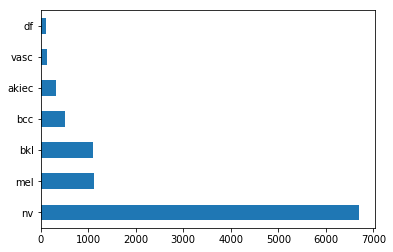

In [23]:
skin['dx'].value_counts().plot.barh();

This chart shows the number of images for each diagnosis are in the dataset. The distribution is far from even, with one particular diagnosis(nv) having the majority of the images. 

### Diagnosis Method Column 

The dx_type column describes how each diagnosis was decided upon. There are four categories, one can imagine that eventually a computer model may a fifth category. The four current categories are:
1. histo:histopathological examination of physically removed cells
2. follow_up:no change in three or more visits or after 1.5 years
3. consensus:same conclusion by two unrelated dermotologists
4. confocal: close visual examination using microscopy

In [20]:
skin.dx_type.value_counts()


histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

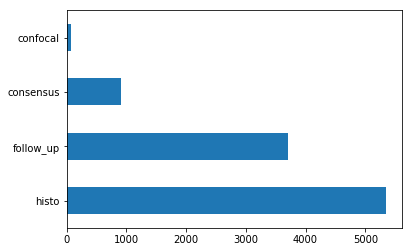

In [22]:
skin['dx_type'].value_counts().plot.barh();


This chart shows how the diagnosis are decided on, histo and follow_up make up most of them.

### Localization column

This column describes where on the body the lesion is located.
1. back                   
2. lower extremity
3. trunk
4. upper extremity
5. abdomen
6. face
7. chest
8. foot
9. unknown
10. neck
11. scalp
12. hand
13. ear
14. genital
15. acral(fingers, toes)

In [24]:
skin['localization'].value_counts()

back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64

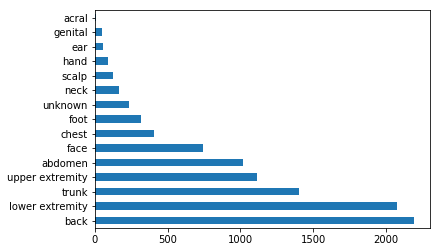

In [25]:
skin['localization'].value_counts().plot.barh();

This chart shows the distribution of the lesion locations- logically most occur on parts of the body with the greatest surface area and those parts that are most exposed to the sun.

### Age column

The chart shows the distribution of patients by age.

In [26]:
skin.age.describe()

count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64

In [ ]:
These are the statistics for the age column.

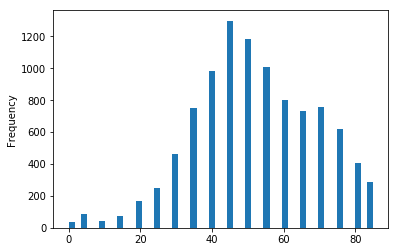

In [27]:
skin['age'].plot.hist(bins=50);

This chart shows the age distribution of the patients.

### Sex Column 

In [28]:
skin['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

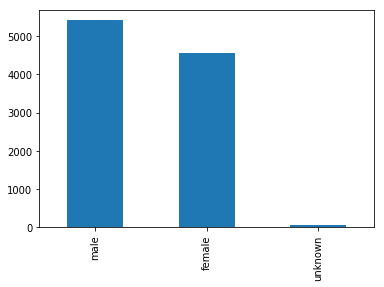

In [29]:
skin['sex'].value_counts().plot.bar();

### Making numbered columns to look for correlations in a heatmap.

In [30]:
skin['dx_num'] = skin['dx'].map({'mel' :1, 'bcc' :2,'nv':0,
                                 'bkl':3,'vasc':4,'df':5,'akiec':6})

In [31]:
skin['dx_type_num'] = skin['dx_type'].map({'histo' :1,'follow_up':2,
                                           'consensus':0,'confocal':3})

In [32]:
skin['localization_num']= skin['localization'].map({'scalp':0, 'ear':1, 'face':2, 'back':3, 'trunk':4, 'chest':5,
       'upper extremity':6, 'abdomen':7, 'unknown':8, 'lower extremity':9,
       'genital':10, 'neck':11, 'hand':12, 'foot':13, 'acral':14})

In [33]:
skin['sex_num']=skin['sex'].map({'male':1, 'female':0})

In [34]:
feature_num=['sex_num','dx_num','dx_type_num',
             'age','localization_num']

In [35]:
skin_num=skin[feature_num]

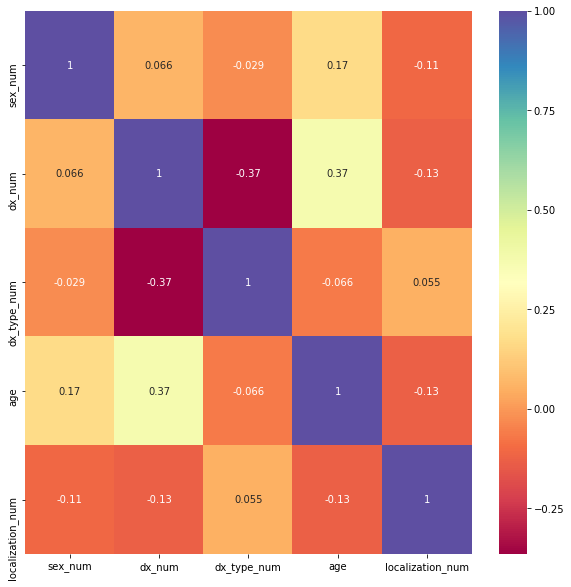

In [38]:
plt.figure(figsize=(10,10))
sns.heatmap(skin_num.corr(), annot=True,cmap='Spectral' );

The heatmap does not show significant relationships between numbered columns. The strongest is between age and diagnosis .37.

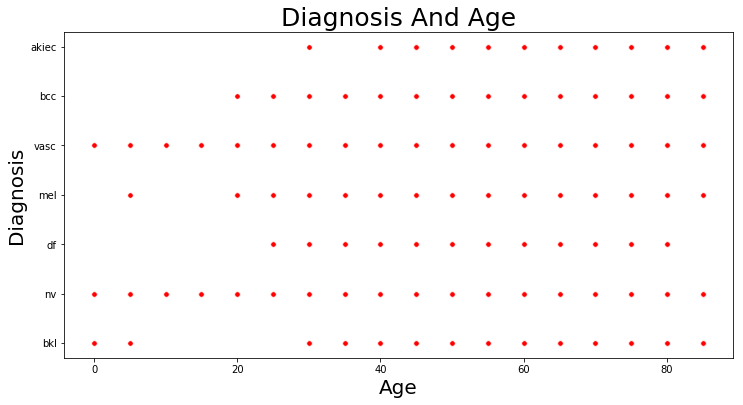

In [39]:
plt.figure(figsize = (12,6))
sns.scatterplot(skin['age'],skin['dx'],
               s=30,
               color ='r')               
plt.xlabel('Age',fontsize=20)
plt.ylabel('Diagnosis',fontsize = 20)
plt.title('Diagnosis And Age',fontsize=25)
plt.show();


The scatterplot above shows that patients over 30 have all seven diagnosis while patients younger than that only have a few.

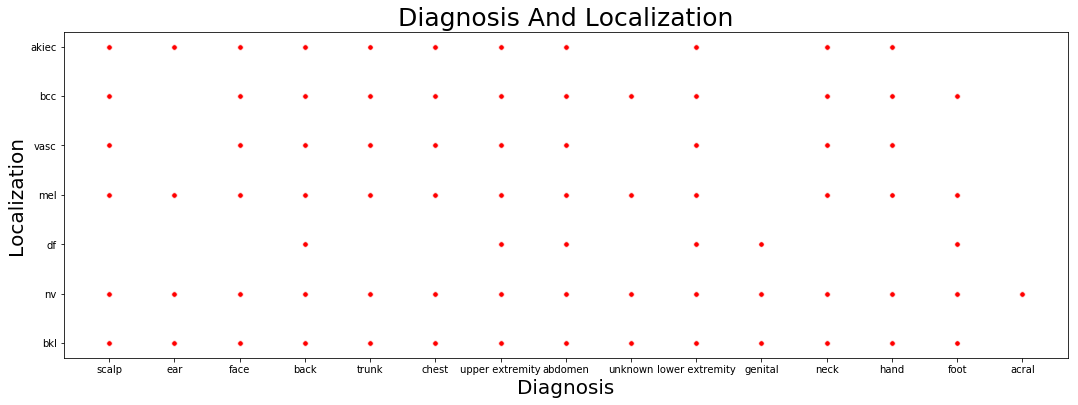

In [40]:
plt.figure(figsize = (18,6))
sns.scatterplot(skin['localization'],skin['dx'],
               s=30,
               color ='r')               
plt.xlabel('Diagnosis',fontsize=20)
plt.ylabel('Localization',fontsize = 20)
plt.title('Diagnosis And Localization',fontsize=25)
plt.show();


The chart above shows certain conditions occur throughout the body surface while others occur in specific areas

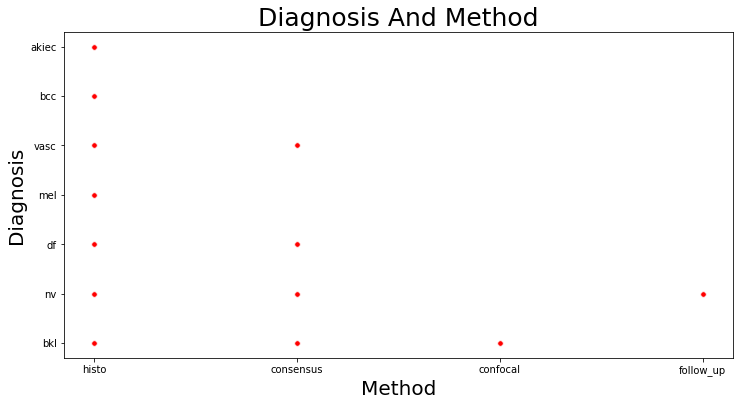

In [41]:
plt.figure(figsize = (12,6))
sns.scatterplot(skin['dx_type'],skin['dx'],
               s=30,
               color ='r')               
plt.xlabel('Method',fontsize=20)
plt.ylabel('Diagnosis',fontsize = 20)
plt.title('Diagnosis And Method',fontsize=25)
plt.show();


Of the four diagnostic methods, histopatholigical(examination by removal) is used for all diagnosis. The use of the other three methods is much more limited.

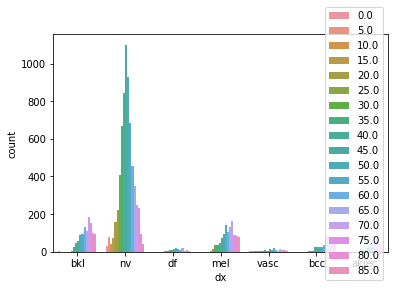

In [42]:
sns.countplot(x='dx',hue='age',data= skin)
plt.legend(loc='right');

This analysis has helped to form an idea for examining the data. Rather than a multiclass classification where the model would try to identify each type lesion, it makes more sense to divide the dataset into malignant and benign subgroups and have a binary classification puzzle instead. Melanoma and carcinoma are in the malignant subgroup, while the balance will make up the benign subgroup. 